In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from scipy.sparse import hstack
from scipy.sparse.csc import csc_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-

In [ ]:
data=pd.read_csv('/content/trainKaggle.csv')

In [ ]:
data

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


# 1.EDA

In [ ]:
class Visualization():
  def __init__(self,data):
    self.data=data
  def target_distribution(self):
    sns.displot(self.data['target'],color="g",bins=30,kde=True)

  def boxplot_target(self):
    sns.boxplot(self.data['target'])

  def standard_error_distribution(self):
    sns.displot(self.data['standard_error'],color="r",bins=30,kde=True)

  def boxplot_standard_error(self):
    sns.boxplot(self.data['standard_error'])

  def distribution_excerpt_len (self):
    sns.displot (list (map(lambda x:len(x.split()),self.data['excerpt'])),color='y',bins=30,kde=True)
  def correlation_matrix (self):
    len_excerpt= list (map(lambda x:len(x.split()),self.data['excerpt']))

    count_punct=[]
    count_stopwords=[]
    stop_words = set(stopwords.words('english'))
    for excerpt in self.data['excerpt']:
      k,i=0,0
      for word in excerpt:
        if (word in string.punctuation):
          k=k+1
        if (word in stop_words):
          i=i+1
      count_stopwords.append(i)
      count_punct.append(k)
  
    df={'target':self.data['target'],'standard_error':self.data['standard_error'],'Длина отрывка ':len_excerpt,'Кол-во знаков препинания':count_punct,
        'Кол-во стоп слов':count_stopwords}
    df=pd.DataFrame(df)
    correlation = df.corr()
    plt.figure(figsize=(10,10))
    sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
    plt.title('Correlation between different fearures')
    plt.show()

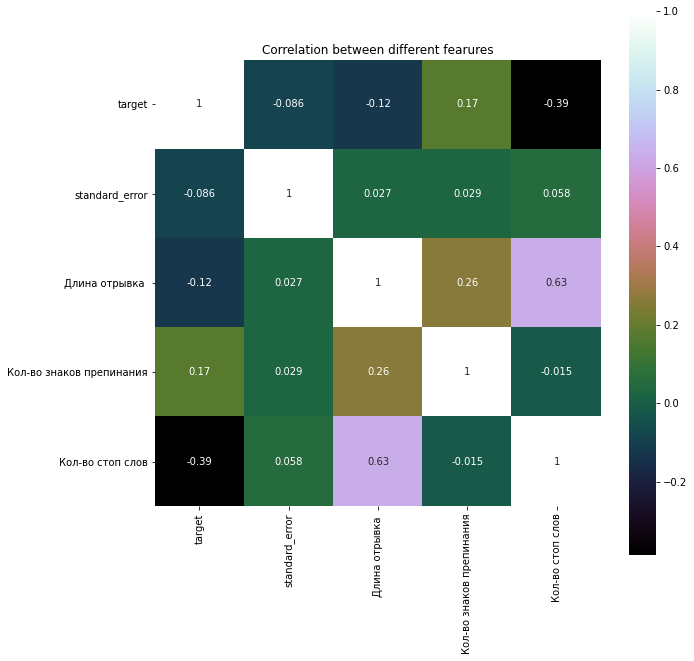

In [ ]:
visualization=Visualization(data)
visualization.correlation_matrix()

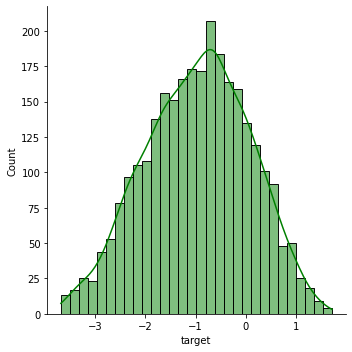

In [ ]:
visualization.target_distribution()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


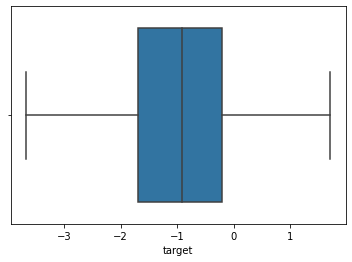

In [ ]:
visualization.boxplot_target()

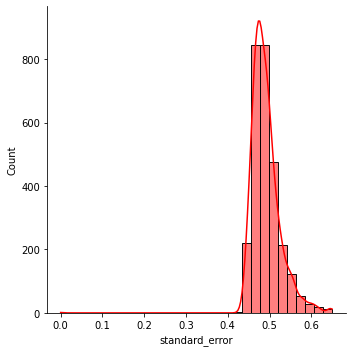

In [ ]:
visualization.standard_error_distribution()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


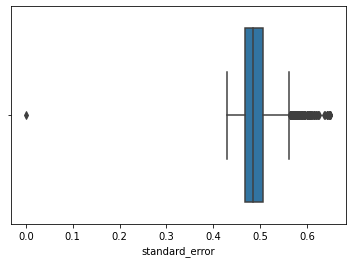

In [ ]:
visualization.boxplot_standard_error()

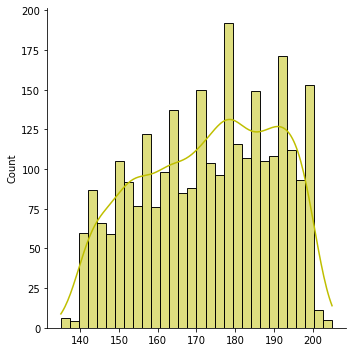

In [ ]:
visualization.distribution_excerpt_len()

# 2.Feature Engineering

In [ ]:
class CLRPdataset():
  def __init__(self,data):
    self.data=data
  def concat_excerpt_url(self):

    def isNaN(num):
      return num != num

    for i,sent in enumerate (self.data['url_legal']):
      if not isNaN(sent):
        sent=sent.split('/')[-2:]
        for j,word in enumerate (sent):
          sent[j]=re.sub('[^\w\s]',' ',word)
          sent[j]=re.sub('_',' ',sent[j])
        s=' '.join(sent)
        self.data['excerpt'][i]=s+' '+self.data['excerpt'][i]

  def generate_other_features(self):
    count_punct=[]
    for excerpt in self.data['excerpt']:
      k=0
      for w in excerpt:
        if w in string.punctuation:
          k+=1
      count_punct.append(k)

    count_char=[len(excerpt) for excerpt in self.data['excerpt']]

    count_words=[len(excerpt.split() ) for excerpt in self.data['excerpt']  ]

    count_uniq_words= [len(set(excerpt.split() ) ) for excerpt in self.data['excerpt']  ]

    count_word_diversity= [count_uniq_words[i]/count_words[i] for i in range (len(count_uniq_words))]

    max_word=[]
    average_word=[]

    for excerpt in self.data['excerpt']:
      word_len=[len(w) for w in (excerpt.split() )]
      max_word.append(np.max(word_len))
      average_word.append(np.mean(word_len))

    return count_punct,count_char,count_words,count_uniq_words,count_word_diversity,max_word,average_word
    

In [ ]:
clrp=CLRPdataset(data)
features=clrp.generate_other_features()
clrp.concat_excerpt_url()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
data=data.drop(['url_legal','id','license'],axis=1)

In [ ]:
data

,excerpt,target,standard_error
0,When the young people returned to the ballroom...,-0.340259,0.464009
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,And outside before the palace a great garden w...,-1.054013,0.450007
4,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...
2829,06 dinosaurs 45 text pdf When you think of din...,1.711390,0.646900
2830,Wikijunior The Elements Solids So what is a so...,0.189476,0.535648
2831,Wikijunior The Elements Liquids The second sta...,0.255209,0.483866
2832,Geometry for Elementary School Solids Solids a...,-0.215279,0.514128


In [ ]:
df={'excerpt':data['excerpt'].values,
    'standard_error':data['standard_error'].values,
    'count_punct':features[0],
    'count_char':features[1],
    'count_words':features[2],
    'count_uniq_words':features[3],
    'word_diversity':features[4],
    'max_word':features[5],
    'average_word':features[6],
    'target':data['target'].values}
data=pd.DataFrame(df)

In [ ]:
data

,excerpt,standard_error,count_punct,count_char,count_words,count_uniq_words,word_diversity,max_word,average_word,target
0,When the young people returned to the ballroom...,0.464009,27,992,179,114,0.636872,11,4.547486,-0.340259
1,"All through dinner time, Mrs. Fayre was somewh...",0.480805,56,937,169,127,0.751479,12,4.550296,-0.315372
2,"As Roger had predicted, the snow departed as q...",0.476676,47,908,166,128,0.771084,14,4.475904,-0.580118
3,And outside before the palace a great garden w...,0.450007,33,909,164,118,0.719512,13,4.548780,-1.054013
4,Once upon a time there were Three Bears who li...,0.510845,32,723,147,51,0.346939,12,3.925170,0.247197
...,...,...,...,...,...,...,...,...,...,...
2829,06 dinosaurs 45 text pdf When you think of din...,0.646900,25,901,145,104,0.717241,15,5.220690,1.711390
2830,Wikijunior The Elements Solids So what is a so...,0.535648,19,890,164,105,0.640244,15,4.432927,0.189476
2831,Wikijunior The Elements Liquids The second sta...,0.483866,25,949,190,100,0.526316,14,4.000000,0.255209
2832,Geometry for Elementary School Solids Solids a...,0.514128,32,864,150,104,0.693333,28,4.766667,-0.215279


# 3.Preproccesing

In [ ]:
class Preproccesing():
  def __init__ (self,data):
    self.data=data
  def low (self):
    self.data= list(map(lambda x: x.lower(),self.data))
    return self.data
  def remove_LineBreak (self):
    self.data= list(map(lambda x: re.sub('\n',' ',x),self.data))
    return self.data
  def remove_punctuation (self):
    pattern=re.compile('[^\w\s]')
    self.data= list(map(lambda x: pattern.sub(' ',x),self.data))
    return self.data
  def remove_stop_words (self):
    filtered_data=[]
    stop_words = set(stopwords.words('english'))
    for sent in (self.data):
      word_tokens = word_tokenize(sent)
      filtered_sentence = [w for w in word_tokens if not w in stop_words]
      filtered_data.append(filtered_sentence)

    for i,sent in enumerate (filtered_data):
      filtered_data[i]=' '.join(sent)
    self.data=filtered_data
    return self.data
    

In [ ]:
preproccesing=Preproccesing(data['excerpt'])
clean_data=preproccesing.low()
clean_data=preproccesing.remove_LineBreak()
clean_data=preproccesing.remove_punctuation()
clean_data=preproccesing.remove_stop_words()

In [ ]:
clean_data=pd.DataFrame({'data':clean_data})

In [ ]:
data['excerpt']=clean_data

In [ ]:
data

,excerpt,standard_error,count_punct,count_char,count_words,count_uniq_words,word_diversity,max_word,average_word,target
0,young people returned ballroom presented decid...,0.464009,27,992,179,114,0.636872,11,4.547486,-0.340259
1,dinner time mrs fayre somewhat silent eyes res...,0.480805,56,937,169,127,0.751479,12,4.550296,-0.315372
2,roger predicted snow departed quickly came two...,0.476676,47,908,166,128,0.771084,14,4.475904,-0.580118
3,outside palace great garden walled round fille...,0.450007,33,909,164,118,0.719512,13,4.548780,-1.054013
4,upon time three bears lived together house woo...,0.510845,32,723,147,51,0.346939,12,3.925170,0.247197
...,...,...,...,...,...,...,...,...,...,...
2829,06 dinosaurs 45 text pdf think dinosaurs lived...,0.646900,25,901,145,104,0.717241,15,5.220690,1.711390
2830,wikijunior elements solids solid solids usuall...,0.535648,19,890,164,105,0.640244,15,4.432927,0.189476
2831,wikijunior elements liquids second state matte...,0.483866,25,949,190,100,0.526316,14,4.000000,0.255209
2832,geometry elementary school solids solids shape...,0.514128,32,864,150,104,0.693333,28,4.766667,-0.215279


# 4.Tokenization

In [ ]:
text=data['excerpt']

In [ ]:
word2idx={'<pad>':0,
          '<unk>':1}

In [ ]:
i=2
for seq in text:
  for w in word_tokenize(seq):
    if w not in word2idx:
      word2idx[w]=i
      i+=1

In [ ]:
tokens=[word_tokenize(seq) for seq in text]

In [ ]:
max_len=max(list(map(lambda x: len(x),tokens)))
vecs=[]
for token in tokens:
  token.extend(['<pad>']*(max_len-len(token)))
  vecs.append([word2idx[w] for w in token])

FastText Embeddings

In [ ]:
!pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
!unzip wiki.en.zip
!rm -rf wiki.en.zip
!rm -rf wiki.en.vec

     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3097858 sha256=1a56d6f6d27b160b84e93dbea10c8643f3154a6e9990c6d26dc20f881b7e69c8
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
--2021-06-28 06:12:49--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356881291 (9.6G) [application/zip]
Saving to: ‘wiki.en.zip’

wiki.en.zip         100%[===================>]   9.65G  34.9MB/s    in 4m 26s  

2021-06-28 06:17:15 (37.2 MB/s) - ‘wiki.en.zip’ saved [10356881291/10356881291]

Archive:  wiki.en.zip
  inflating: wiki.en.vec             
  inflating:

In [ ]:
import fasttext
model_ft = fasttext.load_model('wiki.en.bin')

In [ ]:
emb = [model_ft.get_word_vector(i) for i in word2idx.keys()]
emb = torch.tensor(emb)

In [ ]:
del model_ft

Train and test data

In [ ]:

##  обучающая выборка / тестовая выборка
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    vecs, np.array(data['target']), test_size=0.2, random_state=42)

## перевод в тензоры     
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

## создание объектов dataloader
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data) 
train_dataloader = DataLoader(train_data, sampler=train_sampler)

val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data) 
val_dataloader = DataLoader(val_data, sampler=val_sampler)

# 5.Model

## FastText+ 4 слойная СНС

In [ ]:
class CNN (nn.Module):
  def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 dropout=0.5):
    super(CNN, self).__init__()
    if pretrained_embedding is not None:
      self.vocab_size, self.embed_dim=pretrained_embedding.shape
      self.embedding=nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
    else:  
      self.embed_dim=embed_dim
      self.embedding=nn.Embedding(num_embeddings=self.vocab_size,
                                embedding_dim=self.embed_dim
                                )
    self.conv1d_1=nn.Conv1d(in_channels=300,
                          out_channels=128,
                          kernel_size=3)
    self.conv1d_2=nn.Conv1d(in_channels=128,
                          out_channels=64,
                          kernel_size=3)
    self.conv1d_3=nn.Conv1d(in_channels=64,
                          out_channels=32,
                          kernel_size=3)
    self.conv1d_4=nn.Conv1d(in_channels=32,
                          out_channels=16,
                          kernel_size=3)
    self.linear=nn.Linear(16,1)
    self.dropout=nn.Dropout(p=dropout)
    self.double()
  def forward(self,input):
    out=self.embedding(input)

    out=out.permute(0,2,1)
    out=self.conv1d_1(out)
    out=F.relu(out)
    out=F.max_pool1d(out,3)

    out=self.conv1d_2(out)
    out=F.relu(out)
    out=F.max_pool1d(out,3)

    out=self.conv1d_3(out)
    out=F.relu(out)
    out=F.max_pool1d(out,3)

    out=self.conv1d_4(out)
    out=F.relu(out)
    out=F.max_pool1d(out,2)

    out = out.permute(0, 2, 1)
    out=self.dropout(out)
    y=self.linear(out)
    return y

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [ ]:
num_epochs = 30 
#batch_size = 100 
learning_rate = 0.001

In [ ]:
model = CNN( pretrained_embedding=emb,
            freeze_embedding=False,
            vocab_size=len(word2idx),
            embed_dim=300,
            dropout=0.5)
model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range (num_epochs):
  train_mse=0
  val_mse=0
  print (f'EPOCH {epoch} \n')
  for i,(texts,labels) in enumerate (train_dataloader):
    y=model(texts.cuda())
    optimizer.zero_grad()
    loss = criterion(y[0][0], labels.cuda()) 
    loss.backward()
    optimizer.step()
    train_mse+=loss.item()
  for i,(texts,labels) in enumerate (val_dataloader):
    pred=model(texts.cuda())
    loss=criterion(pred,labels.cuda())
    val_mse+=loss.item()
  print ('TRAIN RMSE=',math.sqrt(train_mse/len(train_labels)))
  print ('VAL RMSE=',math.sqrt(val_mse/len(val_labels)))

EPOCH 0 



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TRAIN RMSE= 0.9564008943101975
VAL RMSE= 0.8784285613487581
EPOCH 1 

TRAIN RMSE= 0.770436346591006
VAL RMSE= 0.8021275746329157
EPOCH 2 

TRAIN RMSE= 0.6260366238508924
VAL RMSE= 0.852964602609321
EPOCH 3 

TRAIN RMSE= 0.5720566387508197
VAL RMSE= 0.7919520057822113
EPOCH 4 

TRAIN RMSE= 0.5494640180777738
VAL RMSE= 0.7933386824294838
EPOCH 5 

TRAIN RMSE= 0.5217328092934567
VAL RMSE= 0.8106503528777443
EPOCH 6 

TRAIN RMSE= 0.5321077146134428
VAL RMSE= 0.8056615709621401
EPOCH 7 

TRAIN RMSE= 0.5073855477663328
VAL RMSE= 0.7956210407487091
EPOCH 8 

TRAIN RMSE= 0.496873571414279
VAL RMSE= 0.7929300821296712
EPOCH 9 



KeyboardInterrupt: ignored

## TF-IDF + SVR

In [ ]:
vectorizer=TfidfVectorizer(ngram_range=(3,5))
data_excerpt_tfidf=vectorizer.fit_transform(data['excerpt'])

In [ ]:
sparce_features=csc_matrix(data.drop(['excerpt','target'],axis=1))

In [ ]:
X=hstack((data_excerpt_tfidf,sparce_features))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,data['target'],test_size=0.2,random_state=42)

In [ ]:
y_train

2743   -1.518350
2347   -0.548807
2387   -0.193262
2202   -1.033799
786    -1.725606
          ...   
1638   -3.309178
1095   -0.216738
1130   -1.584384
1294   -2.034688
860    -0.605216
Name: target, Length: 2267, dtype: float64

In [ ]:
clf=SVR(kernel='linear')
clf.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
pred=clf.predict(X_test)
print (mean_squared_error(pred,y_test,squared=False))

0.954340634417668
